### 1. Load packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score

import SEDR

import WEST_plt

file_path = '/home/stat/cai/WEST/data/cancer/'

2024-05-22 16:03:15.241999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:03:15.511943: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 16:03:16.603857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-22 16:03:16.603991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 2. Load data

In [2]:
#### Read data from pickle
with open(file_path+'raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Preprocess

In [3]:
random_seed = 1234
SEDR.fix_seed(random_seed)

adata.obsm['spatial'] = adata.obs[['loc_x', 'loc_y']].to_numpy()

#### Data preprocess
adata.layers['count'] = adata.X
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=1000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable.
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X



/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 4. Model training

In [4]:
#### Construct neighborhood graph
graph_dict = SEDR.graph_construction(adata, 12)
device='cpu'
#### Training SEDR
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()

adata.obsm['SEDR'] = sedr_feat
SEDR_embedding = sedr_feat

/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/SEDR-1.0.0-py3.8.egg/SEDR/graph_func.py:59: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|          | 0/200 [00:00<?, ?it/s]/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/SEDR-1.0.0-py3.8.egg/SEDR/SEDR_model.py:105: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  total_idx = torch.range(0, self.cell_num-1, dtype=torch.float32).to(self.device)
/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (f

### 4. Clustering

In [7]:
#### Clustering
sc.pp.neighbors(adata, use_rep='SEDR')
sc.tl.leiden(adata, key_added='SEDR', random_state=1234, resolution=0.2)

ARI = adjusted_rand_score(adata.obs['SEDR'], adata.obs["true cluster"])
print("ARI: ", ARI)
print(adata.obs['SEDR'].unique())

ARI:  0.30418576621425497
['1', '0', '2', '3']
Categories (4, object): ['0', '1', '2', '3']


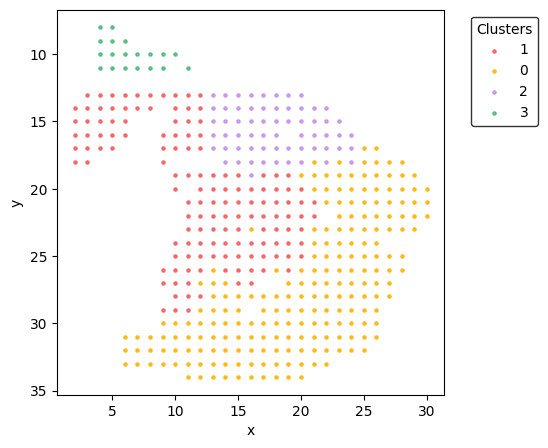

In [8]:
WEST_plt.WEST_scatter(adata, reps='SEDR', invert_y=True, s=5)

### 5. Save embedding

In [9]:
np.savetxt(file_path+'SEDR_embedding.csv',SEDR_embedding, delimiter=',')
np.savetxt(file_path+'SEDR_cluster.csv', adata.obs['SEDR'], delimiter=',', fmt='%s')